<a href="https://colab.research.google.com/github/Jack3690/INSIST/blob/main/INSIST_PSF_Tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/rlwastro/mastcasjobs@master --quiet
!pip install photutils --quiet
!pip install pyxel-sim[all] --quiet
!pip install Jinja2~=2.2

# **GitHub**

In [ ]:
!git clone https://github.com/Jack3690/INSIST

Cloning into 'INSIST'...
remote: Enumerating objects: 1067, done.
remote: Counting objects: 100% (692/692), done.
remote: Compressing objects: 100% (688/688), done.
remote: Total 1067 (delta 401), reused 4 (delta 2), pack-reused 375
Receiving objects: 100% (1067/1067), 120.99 MiB | 7.39 MiB/s, done.
Resolving deltas: 100% (589/589), done.


In [ ]:
cd /content/INSIST/

/content/INSIST


# **Imports**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb

import pyxel
import poppy
import yaml
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.stats import gaussian_fwhm_to_sigma, gaussian_sigma_to_fwhm
from astropy.modeling import models, fitting
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits
from astropy.convolution import Gaussian2DKernel, convolve
from astropy.table import Table

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from matplotlib import colors as col
from astropy.wcs import WCS

from photutils import aperture as aper
from photutils.aperture import aperture_photometry
from photutils.aperture import CircularAperture

from scipy.stats import norm

import os
from time import perf_counter
import json
import requests

import mastcasjobs

# get the WSID and password if not already defined
if not os.environ.get('CASJOBS_USERID'):
    os.environ['CASJOBS_USERID'] = "avinashck90"
if not os.environ.get('CASJOBS_PW'):
    os.environ['CASJOBS_PW'] = "INSIST369"

sb.set_style('darkgrid')
matplotlib.rcParams['font.size']=12
matplotlib.rcParams['figure.figsize']=(10,10)

# **DataFrame to Image**

In [ ]:
class PSF_gen():
  """PSF Generator using Source catalog or CasJobs GALEX Catalog

  Parameters
  ----------
  name (string) : Catalog name or coordinates of the source

  df   (pd.DataFrame ): Pandas dataframe with source catalog

  cols (dict) : dict object with column name conversions for ra,dec,mag_nuv. 
  Eg {'RA': 'ra','Dec' : 'dec', 'ABmag' : 'mag_nuv'}

    'ra' (degrees)

    'dec' (degrees)

    'mag_nuv' (ABmag)

  pixel_scale (float) : pixel scale of detector in the unit 
  of arcseconds/pixels

  fwhm_in (float) : Full Width at Half Maximum of the Gaussian PSF

  n_pix_main (int) : Number of pixels along one axis in the detector. 
  Total number of pixels in the detector is n_pix_main**2

  n_pix_sub (int) : Number of pixels along one axis in the path. Total number 
  of pixels in the patch is n_pix_sub**2

  """
  def __init__(self,name = None, df = None, cols = None, size = 0.01, 
              exp_time = 100, axis = 'on',mode = 'zmax'):   

    self.axis = axis
    self.mode = mode
    self.name = name
    self.cols = cols

    self.radius = size/2
    self.pixel_scale = 0.1
    self.qe          = 0.5
    self.bias        = 10
    self.gain        = 1

    self.M_sky       = 27.5
    self.M_sky_p     = self.M_sky - 2.5*np.log10(self.pixel_scale**2)
    self.DC          = 0.01
    self.RN          = 3
    self.exp_time    = exp_time #seconds
    self.df          = df
    self.init_df()
    self.init_psf_patch() 


  def init_psf_patch(self, return_psf = False):

    self.zero_mag_s_on =  self.exp_time*1.51e3*3631*np.pi*(100/2)**2*(1500/2250)*0.8**6*0.95**2*0.68*0.83 # photons

    self.zero_mag_s_off = self.exp_time*1.51e3*3631*np.pi*(100/2)**2*(1500/2250)*0.8**5*0.95**2*0.83      # photons

    if self.mode == 'zmax':
      if self.axis =='on':
        image =  np.load('/content/INSIST/data/On_PSF_Zmax.npy')
        image /= image.sum()
        self.image_g_sub = image
        F_sky_p           = self.zero_mag_s_on*pow(10,-0.4*self.M_sky_p)
        self.sky_bag_flux = F_sky_p    
        self.zero_flux    = self.zero_mag_s_on 

      elif self.axis=='off':
        image  = np.load('/content/INSIST/data/Off_PSF_Zmax.npy')
        image /= image.sum()
        self.image_g_sub  = image
        F_sky_p           = self.zero_mag_s_off*pow(10,-0.4*self.M_sky_p)
        self.sky_bag_flux = F_sky_p    
        self.zero_flux    = self.zero_mag_s_off 

    elif self.mode =='hcipy':
      if self.axis =='on':
        image  = np.load('/content/INSIST/data/on_axis_hcipy.npy')
        image /= image.sum()
        self.image_g_sub =  image
        F_sky_p           = self.zero_mag_s_on*pow(10,-0.4*self.M_sky_p)
        self.sky_bag_flux = F_sky_p    
        self.zero_flux    = self.zero_mag_s_on  

      elif self.axis=='off':
        image  = np.load('/content/INSIST/data/off_axis_hcipy.npy')
        image /= image.sum()
        self.image_g_sub  = image
        F_sky_p           = self.zero_mag_s_off*pow(10,-0.4*self.M_sky_p)
        self.sky_bag_flux = F_sky_p    
        self.zero_flux    = self.zero_mag_s_off 

    if return_psf:
      return image*self.zero_flux
  def mastQuery(self,request, json_return=False):
    """
    Perform a MAST query.

    Parameters
    ----------
    request (dictionary): The MAST request json object

    Returns the text response or (if json_return=True) the json response
    """

    url = "https://mast.stsci.edu/api/v0/invoke"

    # Encoding the request as a json string
    requestString = json.dumps(request)

    # make the query
    r = requests.post(url, data=dict(request=requestString))

    # raise exception on error
    r.raise_for_status()

    if json_return:
      return r.json()
    else:
      return r.text


  def resolve(self,name):
      """Get the RA and Dec for an object using the MAST name resolver
      
      Parameters
      ----------
      name (str): Name of object

      Returns RA, Dec tuple with position"""

      resolverRequest = {'service':'Mast.Name.Lookup',
                        'params':{'input':name,
                                  'format':'json'
                                  },
                        }
      resolvedObject = self.mastQuery(resolverRequest, json_return=True)
      # The resolver returns a variety of information about the resolved object, 
      # however for our purposes all we need are the RA and Dec
      try:
          objRa = resolvedObject['resolvedCoordinate'][0]['ra']
          objDec = resolvedObject['resolvedCoordinate'][0]['decl']
      except IndexError as e:
          raise ValueError("Unknown object '{}'".format(name))
      return (objRa, objDec)
  

  def init_df(self):     

    if self.name is not None and self.df is None:
      self.name        = self.name
      self.ra,self.dec = self.resolve(self.name)
      print("Input : MASTCasJobs")
      self.jobs = mastcasjobs.MastCasJobs(context="GALEX_Catalogs")
      self.query =   f"""SELECT ra,dec, mag_nuv,mag_fuv 
                          FROM
                          gcat_asc
                          WHERE
                          ra BETWEEN {self.ra} - {self.radius} AND {self.ra}   
                          + {self.radius}
                          AND 
                          dec BETWEEN {self.dec}- {self.radius} AND {self.dec} 
                          + {self.radius}
                      """
      print("Generating Dataframe")
      self.df = self.jobs.quick(self.query, task_name="python cone search").to_pandas()

    else: 
      print("Input : Dataframe.")
      if self.cols is not None:
        self.df = df.rename(columns = self.cols) 
      else :
        self.df =  df
      self.ra   = (self.df['ra'].max()+self.df['ra'].min())/2
      self.dec  = (self.df['dec'].max()+self.df['dec'].min())/2
      self.name = f" RA : {np.round(self.ra,3)} degrees, Dec : {np.round(self.dec,3)} degrees"

  def init_image_array(self, return_img = False):

    self.n_pix_sub  = self.image_g_sub.shape[0]
    del_ra  = self.df.ra.max()  - self.df.ra.min()
    del_dec = self.df.dec.max() - self.df.dec.min()
    
    n_pix_main = del_ra*3600/self.pixel_scale if del_ra>=del_dec else del_dec*3600/self.pixel_scale
  
    self.n_pix_main = int(n_pix_main) + 2*self.n_pix_sub

    if self.n_pix_main <=10000:
      self.image    = np.zeros((self.n_pix_main, self.n_pix_main))
      self.wcs      = self.create_wcs(self.n_pix_main,self.ra, self.dec, self.pixel_scale)
      
    else:
      print("FoV is too big.")


    if return_img:
      return self.image, self.wcs

  def compute_qe_array(self, n_pix):
    self.qe_array =  np.random.normal(loc=self.qe, 
                                      scale=0.01,
                                      size=(n_pix, n_pix))

  def create_wcs(self,npix,ra,dec,pixel_scale):
    """
    Function for creating WCS object for given ra and dec of a field or 
    a catalog using pixel scale and n_pix_main
    """
    w = WCS(naxis=2)
    w.wcs.crpix = [(npix-1)//2, (npix-1)//2]
    w.wcs.cdelt = np.array([-pixel_scale/3600, self.pixel_scale/3600])
    w.wcs.crval = [ra, dec]
    w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
    return w

  def generate_photons(self, image,npix_m, npix_s,df):
    """
    This function creates PSFs based on ABmag and FWHM which  on a 
    small patch (2D array) of size n_pix_sub*n_pix_sub. 
    The patch with the PSF is then added to the image array of size 
    n_pix_main*n_pix_sub using wcs object.
    """
    if npix_s%2 ==0:
      patch_width_l = npix_s//2
      patch_width_r = npix_s//2

    else:
      patch_width_l = npix_s//2 
      patch_width_r = npix_s//2 +1

    for i, row in df.iterrows():

        c = SkyCoord(row['ra'],row['dec'],unit=u.deg)
        pix = self.wcs.world_to_array_index(c)
        ABmag = row['mag_nuv']

        flux  = self.zero_flux*10**(-ABmag/2.5)  # Photo-elec per second

        patch =  flux*self.image_g_sub

        x1 = pix[0] - patch_width_l
        x2 = pix[0] + patch_width_r
        y1 = pix[1] - patch_width_l
        y2 = pix[1] + patch_width_r

        image[ x1: x2, y1:y2 ] += patch

    image   = image[patch_width_l-1:-patch_width_r-1,patch_width_l-1:-patch_width_r-1]

    return image

  def generate_bag_photoelectrons(self,sky=True,DC=False,RN=False):
    self.bag = 0
    if sky:
      self.sky_array = np.random.normal(loc=self.sky_bag_flux, 
                                      scale=np.sqrt(self.sky_bag_flux),
                                      size=(self.n_pix_main,self.n_pix_main))
      
      self.sky_array *= self.qe_array
      self.bag += self.sky_array

    if DC:
      self.DC_array  = np.random.normal(loc=self.DC*self.exp_time, 
                                        scale=np.sqrt(self.DC*self.exp_time,),
                                        size=(self.n_pix_main,self.n_pix_main))
      self.bag += self.DC_array
    if RN:
      self.RN        = np.random.normal(loc=self.RN, 
                                        scale = (self.DC*self.exp_time,)
                                        ,size=(self.n_pix_main,self.n_pix_main))
      self.bag += self.RN_array

  def compute_shot_noise(self,array,type_ = 'gaussian'):
    if type_ == 'gaussian':
        shot_noise = np.random.normal(loc=array, scale=np.sqrt(array))
    elif type_ =='poisson':
        shot_noise = np.random.poisson(lam=array).astype(array.dtype)

    return shot_noise

  def __call__(self,shot_noise = True, type_ = 'gaussian',
                sky = True,DC =False,RN = False, n_stack = 1, stack_type ='median'):
    
    readout_stack = []
    
    for i in range(n_stack):

      self.init_image_array()

      self.photon_array = self.generate_photons(self.image,self.n_pix_main,self.n_pix_sub, self.df)

      self.compute_qe_array(self.photon_array.shape[0])

      self.photoelec_array = self.photon_array*self.qe_array

      if shot_noise:
        self.shot_noise      = self.compute_shot_noise(self.photoelec_array,type_ = 'gaussian')
        self.photoelec_array = self.shot_noise 

      self.n_pix_main = self.photoelec_array.shape[0]

      self.generate_bag_photoelectrons(sky = sky, DC = DC, RN =RN)

      self.charge = self.photoelec_array + self.bag

      self.readout = self.charge + self.bias
      self.readout *= self.gain
      readout_stack.append(self.readout)
    
    readout_stack = np.array(readout_stack)
    if stack_type == 'median':
      self.readout = np.median(readout_stack, axis = 0)
    elif stack_type == 'mean':
      self.readout = np.median(readout_stack, axis = 0)

    self.wcs = self.create_wcs(self.n_pix_main,self.ra,self.dec, self.pixel_scale)

    self.header = self.wcs.to_header()
    
    print("Image generation completed!")
    return self.readout

In [92]:
class PSF(PSF_gen):
  def __init__(self,name = None, df = None, cols = None, size = 0.01, 
                 exp_time = 100, axis = 'on',mode = 'zmax'):
      super().__init__(name, df, cols, size ,exp_time, axis, mode)

  def __call__(self,shot_noise = True, type_ = 'gaussian',sky = True,DC =True,RN = False, n_stack =1, stack_type ='median' ):
    super().__call__(shot_noise, type_, sky,DC,RN, n_stack, stack_type )
    
    if self.axis == 'off':
      zero_p_flux = (2862952172.359942  + self.bias)/self.gain
    else:
      zero_p_flux = (1417932004.7906494 + self.bias)/self.gain

    c          = SkyCoord(self.df['ra'], self.df['dec'],unit=u.deg)
    data       = self.readout
    wcs        = self.wcs
    pix        = wcs.world_to_array_index(c)

    position        = [(i,j) for i,j in zip(pix[1],pix[0])]

    aperture        = CircularAperture(position, r=0.3/0.1)
    ap_pix          = np.count_nonzero(aperture.to_mask()[0])
    aperture_bag    = aper.CircularAnnulus(position, r_in = 0.3/0.1, r_out = 0.6/0.1)
    bag_pix         = np.count_nonzero(aperture_bag.to_mask()[0])

    phot_table  = aperture_photometry(data/self.gain -self.bias, [aperture, aperture_bag])

    phot_table['sky_flux'] = (ap_pix/bag_pix)*phot_table['aperture_sum_1'].value
    phot_table['flux']     = phot_table['aperture_sum_0'].value - (ap_pix/bag_pix)*phot_table['aperture_sum_1'].value

    phot_table['flux_err'] = np.sqrt( (phot_table['flux'].value + phot_table['sky_flux'].value ))

    phot_table['SNR']      = (phot_table['flux'])/( np.sqrt((phot_table['flux'] + phot_table['sky_flux'] + psf.DC*ap_pix*psf.exp_time) + psf.RN**2*ap_pix) )

    phot_table['mag_in']   = psf.df.mag_nuv
    phot_table['mag_0.3']  = -2.5*np.log10(phot_table['flux'].value/(zero_p_flux*psf.exp_time))
    phot_table['mag_err']  = 1.087*phot_table['flux_err'].value/phot_table['flux'].value
    self.phot_table = phot_table


  def show_field(self,figsize=(10,10)):
    """
    Function for creating a scatter plot of sources within the FoV

    Returns
    -------
    fig, ax
    """
    if self.wcs is None :
      self.init_image_array()

    fig, ax = plt.subplots(1,1,figsize=figsize)
    ax.scatter(self.df['ra'],self.df['dec'],marker='.',color='black')
    ax.set_title(f" Requested Center : {self.name} \n FoV : {np.round(self.pixel_scale*(self.n_pix_main-2*self.n_pix_sub )/3600,3)} degrees | {len(self.df)} sources")
    ax.invert_xaxis()
    ax.set_xlabel('RA (Degrees)')
    ax.set_ylabel('Dec (Degrees)')
    return fig,ax

  def show_image(self, source = 'Readout', figsize = (15,10)):
    """
    Function for plotting the simulated field with PSFs

    Returns
    -------
    fig, ax
    """

    fig = plt.figure(figsize = figsize)

    if source =='Readout':
      data  = self.readout
    elif source == 'Sky':
      data = self.sky_array
    elif source == 'DC':
      data = self.DC_array
    elif source == 'RN':
      data = self.RN_array
    elif source == 'QE':
      data = self.qe_array.ravel()

    ax = fig.add_subplot(projection=self.wcs)
    ax.patch.set_edgecolor('black')  
    ax.patch.set_linewidth('3') 
    img = ax.imshow(data,cmap='jet' , norm = col.LogNorm())
    plt.colorbar(img)
    ax.set_title(f'{source} \nRequested center : {self.name}')
    plt.grid(False)
    return fig,ax

  def show_hist(self, source = 'Readout',bins = None,figsize=(15,8)):
    fig, ax = plt.subplots(1,1,figsize=figsize)

    if source =='Readout':
      data  = self.readout.ravel()
    elif source == 'Sky':
      data = self.sky_array.ravel()
    elif source == 'DC':
      data = self.DC_array.ravel()
    elif source == 'RN':
      data = self.RN_array.ravel()
    elif source == 'QE':
      data = self.qe_array.ravel()

    if bins is None:
      bins  = np.arange(data.min(), data.max(), data.std())
    ax.hist(data, bins = bins)
    ax.set_title(f'{source} histogram')
    ax.set_ylabel('Count')
    ax.set_yscale('log')
    return fig, ax

  def writeto(self,name):
    """
    Function for downloading a fits file of simulated field
    """
    if np.all(self.image) !=None:
      hdu = fits.PrimaryHDU(self.charge, header = self.header)
      hdu.wcs = self.wcs
      hdul = fits.HDUList([hdu])
      hdul.writeto(f'{name}',overwrite= True)
    else:
      print("Generate PSF")

In [ ]:
name = input("Enter source name or coordinates : ") or  "M 67"
size = float(input("Enter size of the region (degrees) : ") or "0.02")

Enter source name or coordinates : 
Enter size of the region (degrees) : 


In [ ]:
ra      = [0]
dec     = [0]
mag_nuv = [25]
df      = pd.DataFrame(zip(ra,dec,mag_nuv), columns= ['ra', 'dec', 'mag_nuv'])

In [ ]:
df = Table.read('data/phatm31.fit').to_pandas()

In [93]:
psf = PSF( df = df, size=size, axis='off',mode='hcipy',exp_time = 600)
psf(shot_noise = True ,sky = True ,DC = False, n_stack = 1)

Input : Dataframe.
Image generation completed!


(<Figure size 1080x720 with 2 Axes>,
 <matplotlib.axes._subplots.WCSAxesSubplot at 0x7fdea89c2810>)

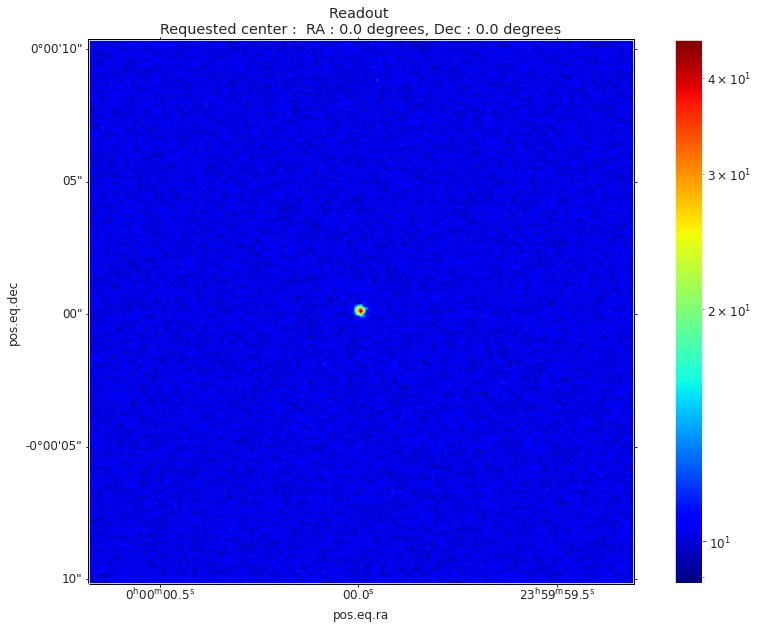

In [94]:
psf.show_image()

In [83]:
psf.phot_table

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,sky_flux,flux,flux_err,SNR,mag_in,mag_0.3,mag_err
,pix,pix,,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64
1,101.0,101.0,195.34627120230977,42.55796305628892,16.509554633905186,178.83671656840457,13.976633042414392,6.061926288275058,25,24.95627164284596,0.08495235435220773


(<Figure size 1080x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdea8eea890>)

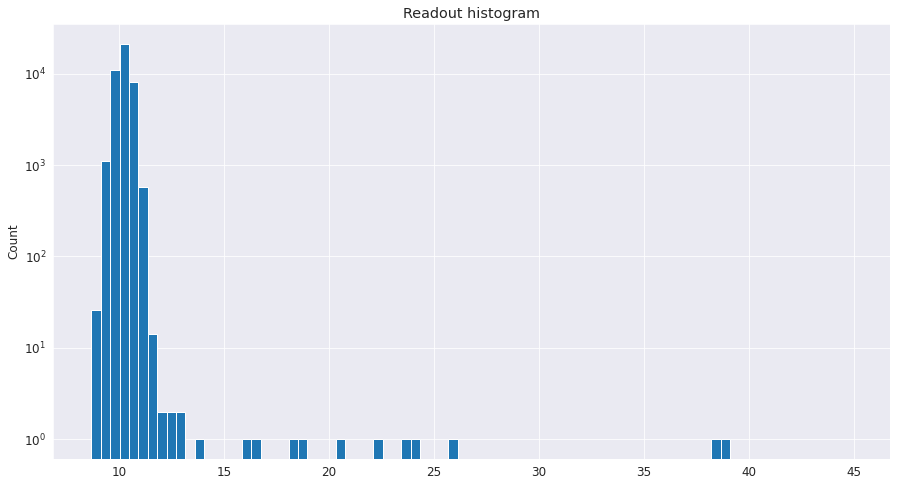

In [84]:
psf.show_hist()

(<Figure size 1080x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdea8c73710>)

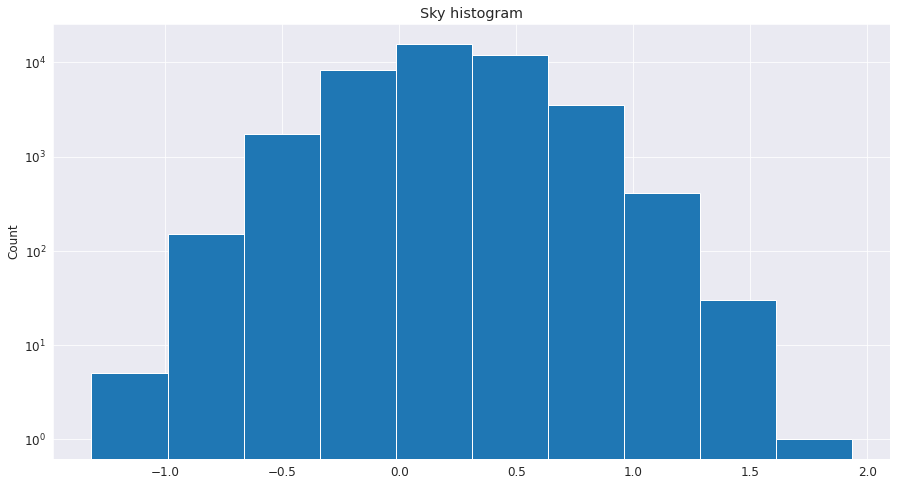

In [85]:
psf.show_hist('Sky')

In [ ]:
psf.show_field()

In [ ]:
psf.writeto('out.fits')

Text(0, 0.5, 'Count')

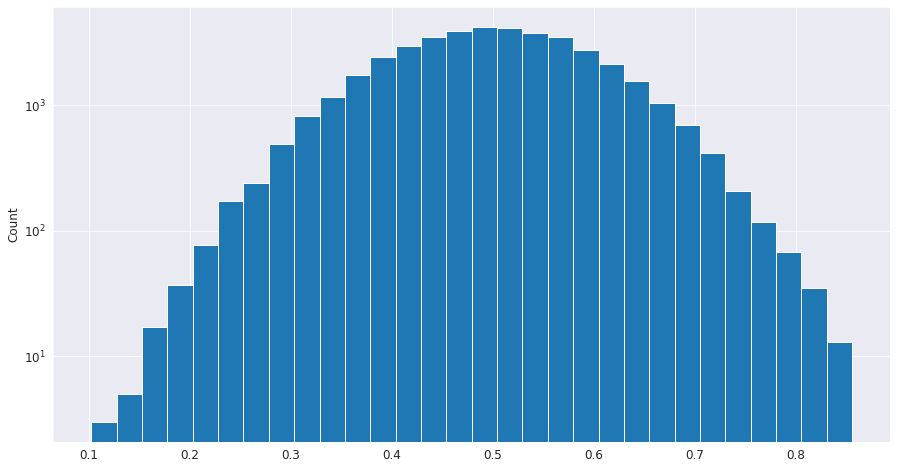

In [ ]:
plt.figure(figsize = (15,8))
data = psf.qe_array.ravel()
bins = np.arange(data.min(), data.max(), 0.25*data.std())
plt.hist(data, bins = bins,)
plt.yscale('log')
plt.ylabel('Count')

In [ ]:
psf.DC_array.sum()

251323.01390078742

Text(0.5, 1.0, 'DC mean : 5.98032')

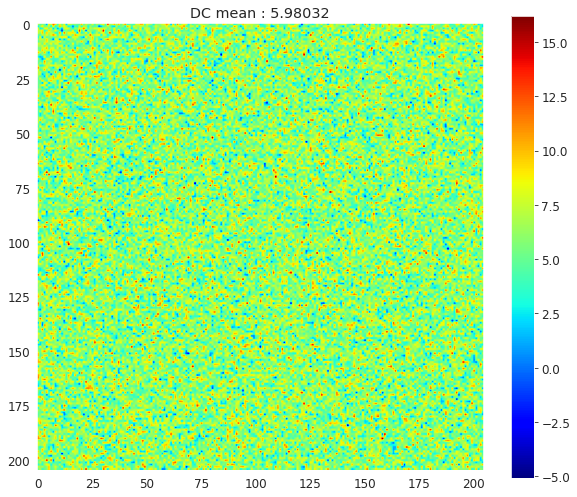

In [ ]:
img = plt.imshow(psf.DC_array, cmap ='jet')
plt.colorbar(img, shrink = 0.85)
plt.grid(False)
plt.title(f'DC mean : {np.round(psf.DC_array.mean(),5)}')

In [ ]:
psf.sky_array.sum()

8827.404153286037

In [ ]:
data.sum()

410.46109321950667

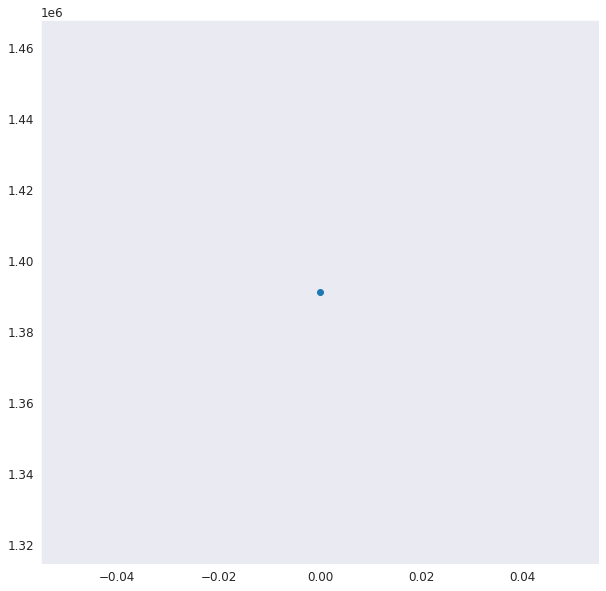

In [ ]:
plt.scatter(psf.phot_table['mag_in'].value, psf.phot_table['SNR'].value)

In [ ]:
psf.phot_table

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,sky_flux,flux,flux_err,SNR,mag_in,mag_0.3,mag_err
,pix,pix,,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64
1,101.0,101.0,2129.432581196756,5103.601208834861,1979.845296530765,149.5872846659911,46.145775334224865,2.968719016944709,24,25.296108296916195,0.3353256789191955


In [ ]:
phot_table

In [ ]:
psf.writeto('/content/INSIST/data/source.fits')

# **Pyxel**

In [ ]:
with open("/content/INSIST/data/exposure_on.yaml",'r') as f:
  dat = yaml.load(f)

In [ ]:
dat['pipeline']['photon_generation'][0]['arguments']['image_file'] = 'data/source.fits'

In [ ]:
dat['pipeline']['optics'][0]['arguments']['fov_arcsec'] = 20.5

In [ ]:
dat['cmos_detector']['geometry']['row']= psf.photon_array.shape[0]
dat['cmos_detector']['geometry']['col']= psf.photon_array.shape[1]
dat['cmos_detector']['geometry']['total_thickness'] = 10

In [ ]:
with open("/content/INSIST/data/exposure_on.yaml", 'w') as out:
  yaml.dump(dat,out)

In [ ]:
config = pyxel.load("/content/INSIST/data/exposure_on.yaml")
exposure = config.exposure  # class Single
detector = config.cmos_detector  # class CMOS
pipeline = config.pipeline  # class DetectionPipeline

In [ ]:
result = pyxel.exposure_mode(exposure=exposure, detector=detector, pipeline=pipeline)
result

/usr/local/lib/python3.7/dist-packages/pyxel/data_structure/photon.py:61: UserWarning: Trying to set negative values in the Photon array! Negative values clipped to 0.
  "Trying to set negative values in the Photon array! Negative values clipped to 0."


Cosmix:   0%|          | 0/100 [00:00<?, ? particle/s]

<xarray.Dataset>
Dimensions:       (readout_time: 1, x: 3785, y: 3785)
Coordinates:
  * readout_time  (readout_time) int64 1
  * y             (y) int64 0 1 2 3 4 5 6 ... 3778 3779 3780 3781 3782 3783 3784
  * x             (x) int64 0 1 2 3 4 5 6 ... 3778 3779 3780 3781 3782 3783 3784
Data variables:
    image         (readout_time, y, x) uint32 3 1 1 3 5 5 6 ... 9 6 7 11 6 10 8
    signal        (readout_time, y, x) float64 0.0003276 0.0001241 ... 0.001178
    pixel         (readout_time, y, x) float64 1.092 0.4137 ... 5.053 3.928

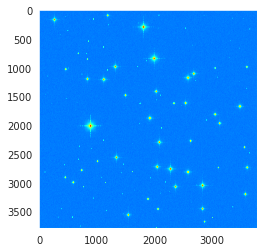

In [ ]:
plt.imshow(result.pixel.data[0], cmap = 'jet', norm = col.LogNorm());

In [ ]:
result.pixel.data[0].max()

100000.0

In [ ]:
hdu = fits.PrimaryHDU(result.pixel.data[0])
hdul = fits.HDUList(hdu)
hdul.writeto('pyxel.fits')

# **Photometry**

In [ ]:
psf = PSF_gen(df = df, size = size,axis='off',mode='hcipy',exp_time = 100)
psf(shot_noise = True, sky = True, DC = True)

c          = SkyCoord(psf.df['ra'],psf.df['dec'],unit=u.deg)
wcs        = WCS(psf.header)
pix        = wcs.world_to_array_index(c)

position        = [(i,j) for i,j in zip(pix[1],pix[0])]

aperture        = CircularAperture(position, r=0.3/0.1)
ap_pix          = np.count_nonzero(aperture.to_mask()[0])
aperture_bag    = aper.CircularAnnulus(position, r_in = 0.3/0.1, r_out = 0.6/0.1)
bag_pix         = np.count_nonzero(aperture_bag.to_mask()[0])

phot_table_off  = aperture_photometry(psf.readout/psf.gain -psf.bias, [aperture, aperture_bag])

phot_table_off['sky_flux'] = (ap_pix/bag_pix)*phot_table_off['aperture_sum_1'].value
phot_table_off['flux']     = phot_table_off['aperture_sum_0'].value - (ap_pix/bag_pix)*phot_table_off['aperture_sum_1'].value

phot_table_off['flux_err'] = np.sqrt( (phot_table_off['flux'].value + phot_table_off['sky_flux'].value ))

phot_table_off['SNR']      = (phot_table_off['flux'])/( np.sqrt((phot_table_off['flux'] + phot_table_off['sky_flux'] + psf.DC*ap_pix) + psf.RN**2*ap_pix) )

phot_table_off['mag_in']   = psf.df.mag_nuv
phot_table_off['mag_0.3']  = -2.5*np.log10(phot_table_off['flux'].value/(1637382539.385776*psf.exp_time))
phot_table_off['mag_err']  = 1.087*phot_table_off['flux_err'].value/phot_table_off['flux'].value
phot_table_off

Reading in DataFrame...
Source catalog generated.
Generating image array...
Generating source photoelectrons....
Generating background...
Image generation completed!


id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,sky_flux,flux,flux_err,SNR,mag_in,mag_0.3,mag_err
,pix,pix,,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64
1,101.0,101.0,332459088833.9597,12833477161.096682,4978504071.115092,327480584762.8446,576592.6541623295,567958.3015827999,0,-0.7525885058389703,1.9138728957881193e-06


In [ ]:
psf = PSF_gen_v3(df = df, size = size,axis='on',mode='hcipy',exp_time = 5000)
psf.simulate_image(shot_noise = True, sky = True, DC = True)
psf.writeto('test_on.fits')
c = SkyCoord(psf.df['ra'],psf.df['dec'],unit=u.deg)
data_b_on  = fits.open('test_on.fits')
wcs        = WCS(data_b_on[0].header)
pix        = wcs.world_to_array_index(c)

position     = [(i,j) for i,j in zip(pix[1],pix[0])]

aperture        = CircularAperture(position, r=0.3/0.1)
ap_pix          = np.count_nonzero(aperture.to_mask()[0])
aperture_bag    = aper.CircularAnnulus(position, r_in = 0.3/0.1, r_out = 0.6/0.1)
bag_pix         = np.count_nonzero(aperture_bag.to_mask()[0])

phot_table_on   = aperture_photometry(data_b_on[0].data/psf.gain -psf.bias, [aperture, aperture_bag])

phot_table_on['sky_flux'] = (ap_pix/bag_pix)*phot_table_on['aperture_sum_1'].value

phot_table_on['flux']     = phot_table_on['aperture_sum_0'].value - phot_table_on['sky_flux'].value

phot_table_on['flux_err'] = np.sqrt( (phot_table_on['flux'].value + phot_table_on['sky_flux'].value ))

phot_table_on['SNR']      = (phot_table_on['flux'].value)/( np.sqrt((phot_table_on['flux'] + phot_table_on['sky_flux'] + psf.DC*ap_pix) + psf.RN**2*ap_pix) )

phot_table_on['mag_in']   = psf.df.mag_nuv
phot_table_on['mag_0.3']  = -2.5*np.log10(phot_table_on['flux'].value/(821562478.8712546*psf.exp_time))
phot_table_on['mag_err']  = 1.087*phot_table_on['flux_err'].value/phot_table_on['flux'].value
phot_table_on

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,sky_flux,flux,flux_err,SNR,mag_in,mag_0.3,mag_err
,pix,pix,,,,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,121.0,111.0,4224633.664415897,300162.3104181041,116442.27559323005,4108191.388822667,2055.391365267427,1998.6433411544488,15.0,14.999899832564658,0.0005438428258538309
2,101.0,111.0,2457.5079831074045,5712.194470364516,2215.9375100552,241.5704730522043,49.57325875013064,4.514777609911435,25.0,25.57641687798839,0.2230658887261731


Text(0.5, 1.0, 'ABmag vs SNR for exposure time of 5000 seconds')

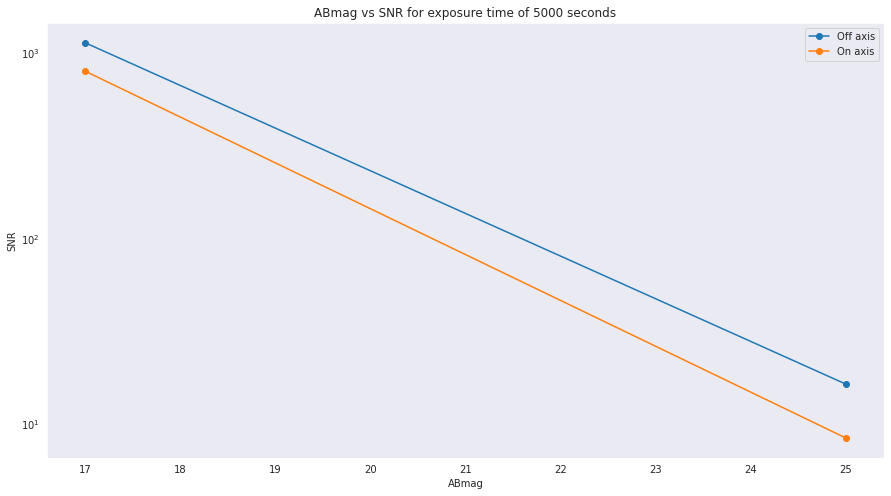

In [ ]:
plt.figure(figsize = (15,8))
plt.plot(phot_table_off['mag_in'].value, phot_table_off['SNR'].value, '-o')
plt.plot(phot_table_on['mag_in'].value, phot_table_on['SNR'].value, '-o')

plt.legend(['Off axis', 'On axis'])
plt.xlabel('ABmag')
plt.ylabel('SNR')
plt.yscale('log')
plt.title(f"ABmag vs SNR for exposure time of {psf.exp_time} seconds")

Text(0.5, 1.0, 'ABmag vs ABmag diff for exposure time of 5000 seconds')

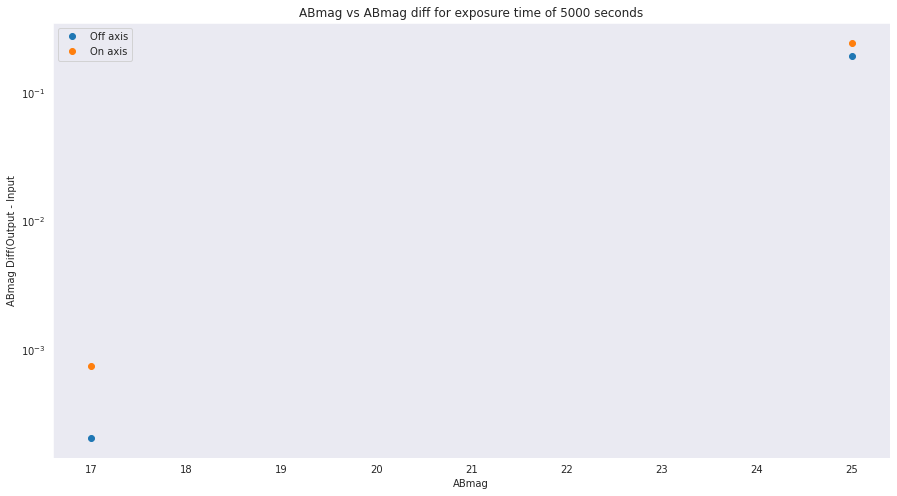

In [ ]:
plt.figure(figsize = (15,8))
plt.plot(phot_table_off['mag_in'].value, phot_table_off['mag_0.3'].value- phot_table_off['mag_in'].value, 'o')
plt.plot(phot_table_on['mag_in'].value, phot_table_on['mag_0.3'].value - phot_table_on['mag_in'].value, 'o')

plt.legend(['Off axis', 'On axis'])
plt.xlabel('ABmag')
plt.ylabel('ABmag Diff(Output - Input')
plt.yscale('log')
plt.title(f"ABmag vs ABmag diff for exposure time of {psf.exp_time} seconds")

In [ ]:
sky_flux_diff = phot_table_on['sky_flux'].value[1] -phot_table_off['sky_flux'].value[1]

-2.5*np.log10(sky_flux_diff/(821562478.8712546*psf.exp_time))

26.24499230952706

In [ ]:
16:02:51.17

SyntaxError: ignored

In [ ]:
16 + 2/60 + 51.17/3600

16.047547222222224

In [ ]:
16.047547222222224*15

240.71320833333337

In [ ]:
-24:01:50.45

In [ ]:
24 + 1/60 + 50.45/3600

24.030680555555556